In [3]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

from keras import Sequential
from keras.layers import Dense

import keras_tuner as kt

import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers
import rasterio

In [4]:
### Direct method, where both image and mask has same dimensions.

# Initialize MinMaxScaler
minmaxscaler = MinMaxScaler()

image_patch_size = 1024 # Patch size

# Root folder of your dataset
dataset_root_folder = r"\Germany\Files"
dataset_name = '1m_s2_files'

image_dataset = []
mask_dataset = []

# Loop through image and mask types
for image_type in ['images', 'mask']:
    # Set the correct file extension for GeoTIFF
    image_extension = 'tif'  # GeoTIFF extension

    for image_id in range(0, 6000):  # Adjust the range as needed
        image_path = f'{dataset_root_folder}/{dataset_name}/{image_type}/image_{image_id}.{image_extension}'
        
        if not os.path.exists(image_path):
            continue  # Skip if the image does not exist

        # Open the GeoTIFF file using rasterio
        with rasterio.open(image_path) as src:
            image = src.read()  # Read all bands
            image = np.moveaxis(image, 0, -1)  # Reorder axes to (height, width, channels)

        # Check if the image has more than 3 channels (e.g., RGBA or additional bands)
        if image.shape[2] > 3:
            image = image[:, :, :3]  # Keep only the first 3 channels (RGB)

        # Convert 16-bit unsigned integers to 8-bit integers (normalize to 0-255)
        if image.dtype == np.uint16:  # Check if the image is 16-bit
            image = (image / 256).astype(np.uint8)  # Scale down to 8-bit (0-255)

        # Resize image to be divisible by patch size
        size_x = (image.shape[1] // image_patch_size) * image_patch_size
        size_y = (image.shape[0] // image_patch_size) * image_patch_size

        print(f"Processing image with dimensions: {image.shape[0]}x{image.shape[1]}, Channels: {image.shape[2]}")

        # Patchify the image
        patched_images = patchify(image, (image_patch_size, image_patch_size, image.shape[2]), step=image_patch_size)

        # Append patches to the dataset
        for i in range(patched_images.shape[0]):
            for j in range(patched_images.shape[1]):
                if image_type == 'images':
                    individual_patched_image = patched_images[i, j, 0]
                    # Normalize the patch
                    individual_patched_image = minmaxscaler.fit_transform(
                        individual_patched_image.reshape(-1, individual_patched_image.shape[-1])
                    ).reshape(individual_patched_image.shape)
                    image_dataset.append(individual_patched_image)
                elif image_type == 'mask':
                    individual_patched_mask = patched_images[i, j, 0]
                    mask_dataset.append(individual_patched_mask)

# Convert lists to numpy arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Optionally save datasets to disk
# np.save(os.path.join(dataset_root_folder, dataset_name, 'image_dataset1.npy'), image_dataset)
# np.save(os.path.join(dataset_root_folder, dataset_name, 'mask_dataset1.npy'), mask_dataset)

print(f"Image dataset shape: {image_dataset.shape}")
print(f"Mask dataset shape: {mask_dataset.shape}")


# Print lengths of datasets
print("Length of image dataset:", len(image_dataset))
print("Length of mask dataset:", len(mask_dataset))

Processing image with dimensions: 7709x8111, Channels: 3
Processing image with dimensions: 7769x8098, Channels: 3
Processing image with dimensions: 7768x7968, Channels: 3
Processing image with dimensions: 7907x8879, Channels: 3
Processing image with dimensions: 7899x8466, Channels: 3
Processing image with dimensions: 7889x8181, Channels: 3
Processing image with dimensions: 7941x8359, Channels: 3
Processing image with dimensions: 7945x8342, Channels: 3
Processing image with dimensions: 8897x10843, Channels: 3
Processing image with dimensions: 8905x10874, Channels: 3
Processing image with dimensions: 8912x10892, Channels: 3
Processing image with dimensions: 8919x10923, Channels: 3
Processing image with dimensions: 8925x10940, Channels: 3
Processing image with dimensions: 7987x8451, Channels: 3
Processing image with dimensions: 7974x8375, Channels: 3
Processing image with dimensions: 8063x8999, Channels: 3
Processing image with dimensions: 8058x8817, Channels: 3
Processing image with dime

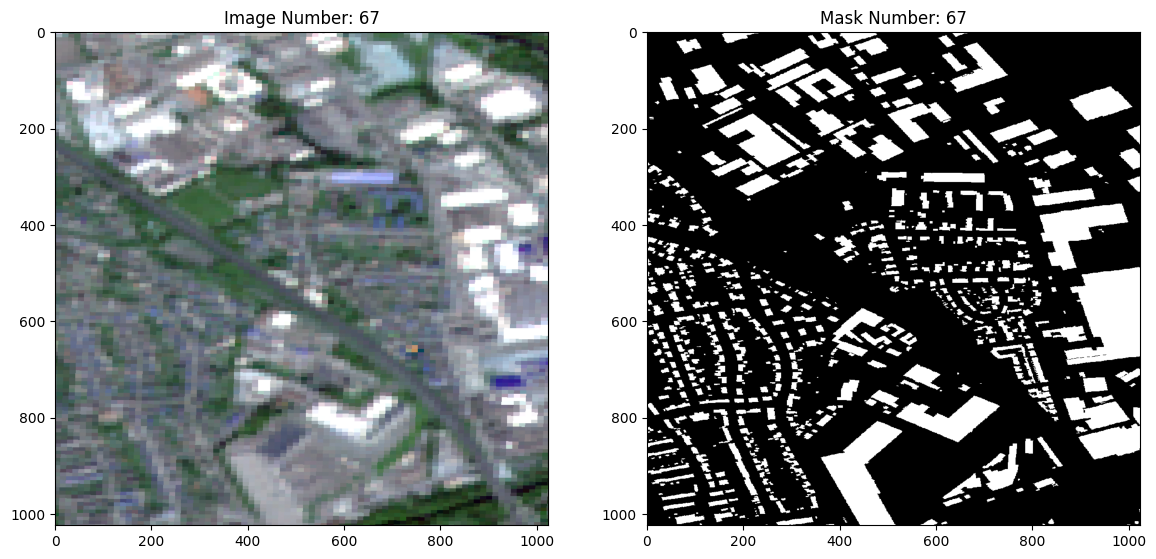

In [5]:
import random
from matplotlib import pyplot as plt

# Select a random patch for display
image_number = random.randint(0, len(image_dataset) - 1)

plt.figure(figsize=(14, 8))

# Display the image with selected bands for RGB visualization (using the first three bands)
plt.subplot(121)
plt.imshow(image_dataset[image_number][..., :3])  # Use only the first three channels for RGB display
plt.title(f'Image Number: {image_number}')

# Display the mask as a grayscale image
plt.subplot(122)
plt.imshow(mask_dataset[image_number].squeeze(), cmap='gray')  # Squeeze to remove the last dimension for grayscale
plt.title(f'Mask Number: {image_number}')

plt.show()

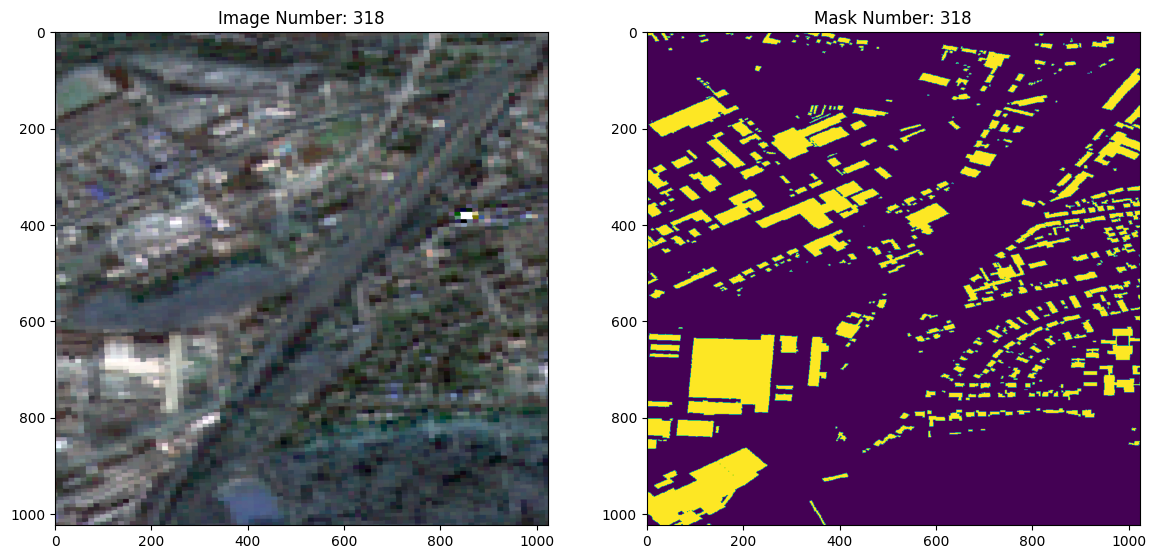

In [6]:
# Assume image_dataset and mask_dataset are your datasets
image_number = random.randint(0, len(image_dataset) - 1)

plt.figure(figsize=(14, 8))

# Display the image with the image number
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.title(f'Image Number: {image_number}')

# Display the mask with the mask number (same as image number in this case)
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.title(f'Mask Number: {image_number}')


plt.show()

In [7]:
### Assuming label pixel value rather than color

label = individual_patched_mask

import numpy as np

# Assuming mask_dataset contains masks with pixel values where:
# 1 = Building
# 0 = Background

def rgb_to_label(label):
    # If the input mask is 3D, we take only the first channel
    # Typically, mask images may be RGB (3-channel), but the values are same across channels
    label_segment = np.zeros(label.shape[:2], dtype=np.uint8)  # Initialize label array with 2D shape
    # Using only one channel for the classification (assuming the image is grayscale or a single band is enough)
    label_segment[label[:, :, 0] == 1] = 1  # Assign building class (1) based on the first channel
    label_segment[label[:, :, 0] == 0] = 0  # Assign background class (0) based on the first channel
    return label_segment

# Convert all mask images in the dataset
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)  # Add back the channel dimension if needed

# Print unique labels to confirm the mask conversion
print("Total unique labels based on masks: ", np.unique(labels))

Total unique labels based on masks:  [0 1]


Randomly selected image ID: 1010


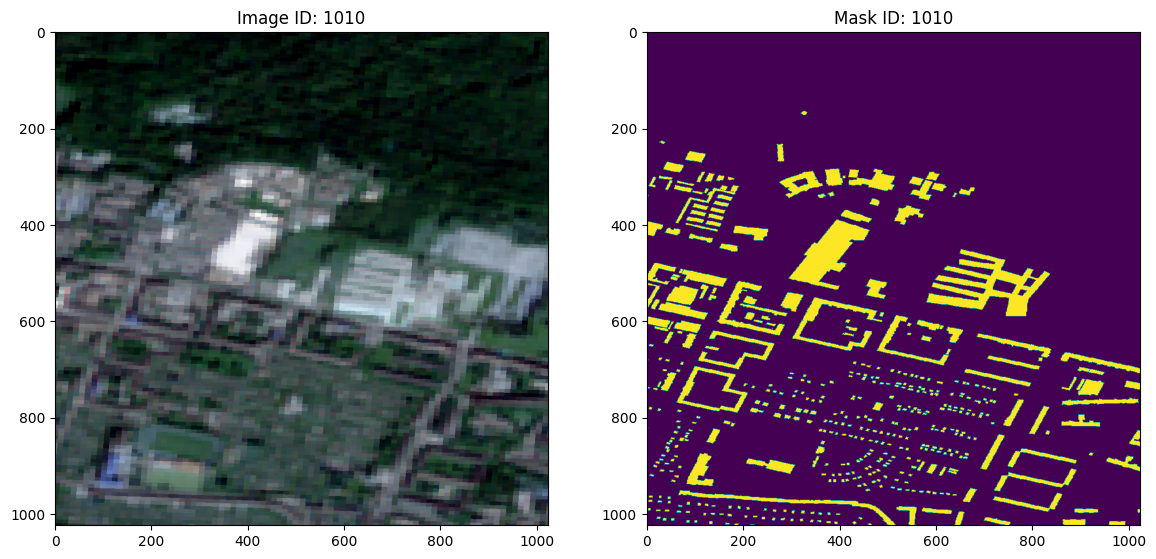

In [10]:
# visualization 

# Generate a random index within the range of the dataset
random_image_id = random.randint(0, len(image_dataset) - 1)

# Print the randomly selected image ID
print(f"Randomly selected image ID: {random_image_id}")

# Plot the image and corresponding mask
plt.figure(figsize=(14, 8))

plt.subplot(121)
plt.title(f"Image ID: {random_image_id}")
plt.imshow(image_dataset[random_image_id])

plt.subplot(122)
plt.title(f"Mask ID: {random_image_id}")
plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:, :, 0], alpha=0.5)

plt.show()

In [9]:
n_classes = len(np.unique(labels))
n_classes

from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)


print(len(np.unique(labels)))
print(labels_cat.shape)

2
(1386, 1024, 1024, 2)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.1, random_state = 42) ## can change test_size and random_state on usecases

print(X_train.shape)  ## Imagery
print(X_test.shape)
print(y_train.shape)   ## labels
print(y_test.shape)

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

KeyboardInterrupt: 

In [12]:
### 

### USING DATA GENERATORS to use as chunks of data 

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Generate indices for training and testing sets
indices = np.arange(len(image_dataset))
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)

# Get sample shapes from the first training and testing indices
sample_train_image = image_dataset[train_indices[0]]  # X_train sample
sample_train_label = labels_cat[train_indices[0]]     # y_train sample
sample_test_image = image_dataset[test_indices[0]]    # X_test sample
sample_test_label = labels_cat[test_indices[0]]       # y_test sample

# Print shapes
print(f"X_train shape: {(len(train_indices), *sample_train_image.shape)}")  ## Imagery
print(f"X_test shape: {(len(test_indices), *sample_test_image.shape)}")
print(f"y_train shape: {(len(train_indices), *sample_train_label.shape)}")   ## labels
print(f"y_test shape: {(len(test_indices), *sample_test_label.shape)}")

# Get image and label dimensions
image_height = sample_train_image.shape[0]
image_width = sample_train_image.shape[1]
image_channels = sample_train_image.shape[2]
total_classes = sample_train_label.shape[2]  # Assuming y_train has shape (n_samples, height, width, num_classes)

print(f"Image height: {image_height}")
print(f"Image width: {image_width}")
print(f"Image channels: {image_channels}")
print(f"Total classes: {total_classes}")

# Custom data generator class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, indices, batch_size=32, shuffle=True):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[k] for k in batch_indices]
        batch_labels = [self.labels[k] for k in batch_indices]
        
        X = np.array(batch_images)
        y = np.array(batch_labels)
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create generators for training and testing
batch_size = 32
train_generator = DataGenerator(image_dataset, labels_cat, train_indices, batch_size=batch_size)  # X_train, y_train
test_generator = DataGenerator(image_dataset, labels_cat, test_indices, batch_size=batch_size, shuffle=False)  # X_test, y_test

# Example model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(total_classes, activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model using the generators
# model.fit(train_generator, validation_data=test_generator, epochs=10)


X_train shape: (1247, 1024, 1024, 3)
X_test shape: (139, 1024, 1024, 3)
y_train shape: (1247, 1024, 1024, 2)
y_test shape: (139, 1024, 1024, 2)
Image height: 1024
Image width: 1024
Image channels: 3
Total classes: 2


In [13]:
import tensorflow
from PIL import Image
import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
weights = [ 0.5, 0.5 ]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

Segmentation Models: using `keras` framework.


In [14]:
def multi_unet_model(n_classes=2, IMG_HEIGHT=1024, IMG_WIDTH=1024, IMG_CHANNELS=3):
#Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs
  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.2)(c1)  # Original 0.1
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.2)(c2)  # Original 0.1
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.2)(c8)  # Original 0.1
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.2)(c9)  # Original 0.1
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the main program to make it easy to test with various loss functions
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()

  return model

In [15]:
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=image_height, IMG_WIDTH=image_width, IMG_CHANNELS=image_channels)

model = get_model()


In [16]:
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

model.summary()

model.input.shape

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 dropout (Dropout)              (None, 1024, 1024,   0           ['conv2d[0][0]']                 
                                16)                                                           

 dropout_3 (Dropout)            (None, 128, 128, 12  0           ['conv2d_6[0][0]']               
                                8)                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 128, 128, 12  147584      ['dropout_3[0][0]']              
                                8)                                                                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 128)  0          ['conv2d_7[0][0]']               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 64, 64, 256)  295168      ['max_pooling2d_3[0][0]']        
                                                                                                  
 dropout_4

TensorShape([None, 1024, 1024, 3])

In [ ]:
#### Training for direct X-train and  y_train

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(
    r"Germany_POC_2_1m_s2_1000images_1024size_checkpoint_{epoch:02d}_full_model.h5",
    monitor='val_loss',
    save_best_only= False,  # Set to False to save at each epoch
    save_weights_only=False,  # Set to False to save the entire model
    mode="auto",
    save_freq="epoch"
)

# Fit the model with callbacks
model_final = model.fit(
    X_train, y_train,
    batch_size=32,
    verbose=1,
    epochs=100,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=[checkpoint]
)


In [18]:
model.save(r"Germany_1400images_1m_1024size_checkpoint_120_full_model.h5")


In [17]:
#### Training for start from generators

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(
    r"Germany_1400images_1m_1024size_checkpoint_{epoch:02d}_full_model.h5",
    monitor='val_loss',
    save_best_only= True,  # Set to False to save at each epoch
    save_weights_only=False,  # Set to False to save the entire model
    mode="auto",
    save_freq="epoch"
)

# Fit the model with callbacks

model_final = model.fit(train_generator,
                  batch_size=32,
                  epochs=120,
                
                  verbose=1,
                  validation_data=test_generator,
                  shuffle=False,
                  callbacks=[checkpoint])


Epoch 1/120
38/38 [==============================] - 3542s 93s/step - loss: 0.4415 - accuracy: 0.9022 - jacard_coef: 0.5828 - val_loss: 0.2810 - val_accuracy: 0.9120 - val_jacard_coef: 0.6957
Epoch 2/120
38/38 [==============================] - 3540s 93s/step - loss: 0.2632 - accuracy: 0.9110 - jacard_coef: 0.7316 - val_loss: 0.2508 - val_accuracy: 0.9120 - val_jacard_coef: 0.7788
Epoch 3/120
38/38 [==============================] - 3724s 98s/step - loss: 0.2506 - accuracy: 0.9111 - jacard_coef: 0.7410 - val_loss: 0.2365 - val_accuracy: 0.9120 - val_jacard_coef: 0.7669
Epoch 4/120
38/38 [==============================] - 3684s 97s/step - loss: 0.2406 - accuracy: 0.9113 - jacard_coef: 0.7494 - val_loss: 0.2593 - val_accuracy: 0.9120 - val_jacard_coef: 0.8040
Epoch 5/120
38/38 [==============================] - 3806s 100s/step - loss: 0.2365 - accuracy: 0.9110 - jacard_coef: 0.7525 - val_loss: 0.2422 - val_accuracy: 0.9120 - val_jacard_coef: 0.7935
Epoch 6/120
38/38 [====================

In [3]:
### Filterig label mask of proper area for saving, or training wrt small buildings

import rasterio
import numpy as np
from scipy.ndimage import label
from skimage.measure import regionprops

# Define pixel size in meters (assuming 1.17 meters per pixel)
pixel_size = 1.17
min_area_sqm = 25  # Minimum area threshold in square meters
min_pixel_count = min_area_sqm / (pixel_size ** 2)  # Calculate the minimum pixel count

# Load the binary TIFF file with building mask
input_tiff_path = r"\mask\image_1084.tif"
output_tiff_path = r"transformed_tiff_test\filtered_buildings_15sqm.tif"

with rasterio.open(input_tiff_path) as src:
    mask_data = src.read(1)  # Read the first band assuming it's binary (1: building, 0: background)
    profile = src.profile  # Save profile to use for output file

# Label connected components in the binary mask
labeled_mask, num_features = label(mask_data)

# Create an empty array for the filtered output
filtered_mask = np.zeros_like(mask_data, dtype=np.uint8)

# Analyze properties of each labeled region
for region in regionprops(labeled_mask):
    # Calculate the area in pixel counts
    if region.area < min_pixel_count:
        # If the area is less than the threshold, keep it in the filtered mask
        for coords in region.coords:
            filtered_mask[coords[0], coords[1]] = 1

# Save the filtered mask as a new TIFF file
profile.update(dtype=rasterio.uint8)  # Update profile to ensure data type compatibility

with rasterio.open(output_tiff_path, "w", **profile) as dst:
    dst.write(filtered_mask, 1)

print("Filtered TIFF saved with areas below 15 sqm.")


Filtered TIFF saved with areas below 15 sqm.


In [4]:
import rasterio
import numpy as np
from scipy.ndimage import label
from skimage.measure import regionprops

# Define pixel size in meters (adjust as necessary for your data)
pixel_size = 1.17  # Replace with the actual pixel size of your TIFF file
min_area_sqm = 30  # Minimum area threshold in square meters
min_pixel_count = min_area_sqm / (pixel_size ** 2)  # Calculate the minimum pixel count

# Load the binary TIFF file with building mask
input_tiff_path = r"mask\image_1084.tif"
output_tiff_path = r"filtered_image_1084.tif"

with rasterio.open(input_tiff_path) as src:
    mask_data = src.read(1)  # Read the first band assuming it's binary (1: building, 0: background)
    profile = src.profile  # Save profile to use for output file

# Label connected components in the binary mask
labeled_mask, num_features = label(mask_data)

# Create an empty array for the filtered output
filtered_mask = np.zeros_like(mask_data, dtype=np.uint8)

# Analyze properties of each labeled region
for region in regionprops(labeled_mask):
    # Calculate the area in pixel counts
    if region.area < min_pixel_count:
        # If the area is less than the threshold, keep it in the filtered mask
        for coords in region.coords:
            filtered_mask[coords[0], coords[1]] = 1

# Save the filtered mask as a new TIFF file
with rasterio.open(output_tiff_path, "w", **profile) as dst:
    dst.write(filtered_mask, 1)

print("Filtered TIFF saved with areas below 15 sqm.")


Filtered TIFF saved with areas below 15 sqm.


In [12]:
## Resuming training from where it got stopped

import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K



last_checkpoint = r"Germany_POC_2_1m_s2_1000images_1024size_checkpoint_54_full_model.h5"
model = load_model(last_checkpoint, custom_objects={
    'jacard_coef': jacard_coef,
    'total_loss': total_loss,
    'DiceLoss': sm.losses.DiceLoss,
    'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss})

### With data generators

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(r"\Germany_POC_2_1m_s2_1000images_1024size_checkpoint_{epoch:02d}_full_model.h5", 
                             monitor='val_loss', save_best_only=False,
                            save_weights_only=False,
                            mode="auto",
                            save_freq="epoch",
                            initial_value_threshold=None)


initial_epoch = 54
total_epochs = 100

# Fit the model with callbacks using the generators
final = model.fit(train_generator,
                  batch_size=16,

                  epochs=total_epochs,
                  
                  initial_epoch=initial_epoch,
                  verbose=1,
                  validation_data=test_generator,
                  shuffle=True,
                  callbacks=[checkpoint])



Epoch 55/100
31/31 [==============================] - 1825s 57s/step - loss: 0.1649 - accuracy: 0.9303 - jacard_coef: 0.8174 - val_loss: 0.2001 - val_accuracy: 0.9225 - val_jacard_coef: 0.8076
Epoch 56/100
31/31 [==============================] - 1818s 56s/step - loss: 0.1639 - accuracy: 0.9305 - jacard_coef: 0.8177 - val_loss: 0.1858 - val_accuracy: 0.9277 - val_jacard_coef: 0.8201
Epoch 57/100
31/31 [==============================] - 1642s 52s/step - loss: 0.1642 - accuracy: 0.9304 - jacard_coef: 0.8179 - val_loss: 0.1906 - val_accuracy: 0.9277 - val_jacard_coef: 0.8221
Epoch 58/100
31/31 [==============================] - 1599s 51s/step - loss: 0.1608 - accuracy: 0.9319 - jacard_coef: 0.8213 - val_loss: 0.2015 - val_accuracy: 0.9239 - val_jacard_coef: 0.8205
Epoch 59/100
31/31 [==============================] - 1655s 52s/step - loss: 0.1608 - accuracy: 0.9320 - jacard_coef: 0.8213 - val_loss: 0.2040 - val_accuracy: 0.9246 - val_jacard_coef: 0.8224
Epoch 60/100
31/31 [===============

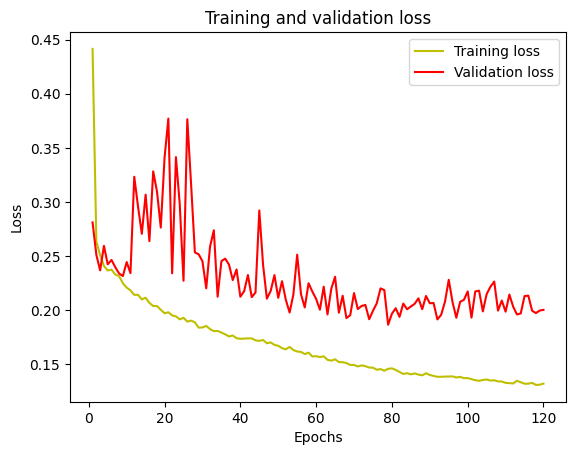

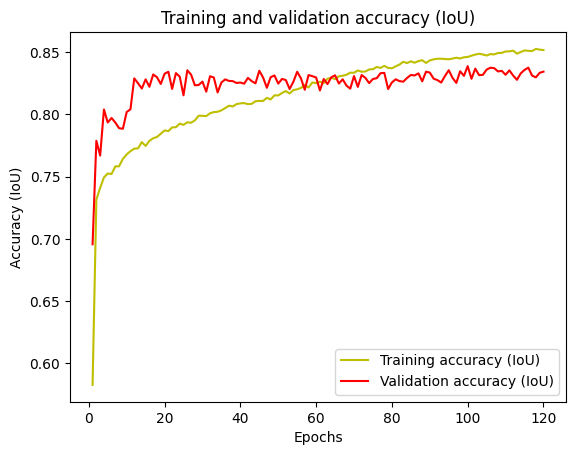

In [19]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
history= model_final
# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy (or IoU if you tracked IoU)
acc = history.history['jacard_coef']  # Assuming 'jacard_coef' is recorded during training
val_acc = history.history['val_jacard_coef']  # Assuming 'val_jacard_coef' is recorded during training

plt.plot(epochs, acc, 'y', label='Training accuracy (IoU)')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy (IoU)')
plt.title('Training and validation accuracy (IoU)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (IoU)')
plt.legend()
plt.show()


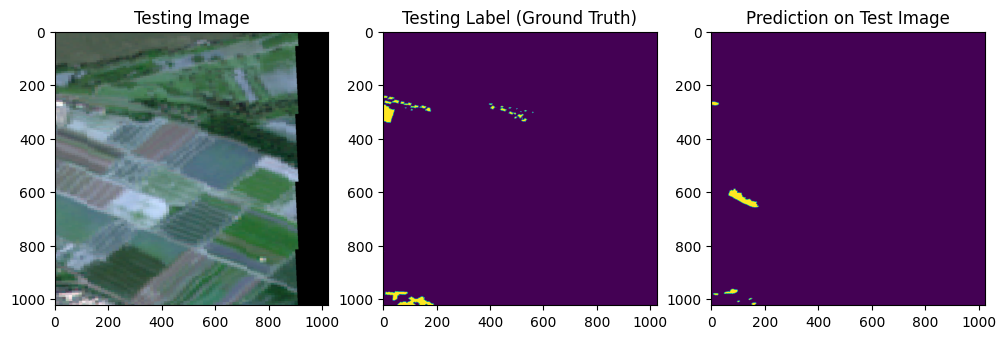

In [24]:
####  Test generator predictions

import numpy as np
import matplotlib.pyplot as plt
import random

# Step 1: Pick a random image from the test generator
test_img_number = random.randint(0, len(test_generator) - 1)

# Extract a batch of images and labels from the generator
test_batch = test_generator[test_img_number]
test_img = test_batch[0]  # This is the batch of images (X_test)
test_label = test_batch[1]  # This is the batch of labels (y_test)

# Step 2: Select one image and corresponding label from the batch
test_img_single = test_img[0]  # The first image in the batch
ground_truth_single = test_label[0]  # The corresponding label

# Step 3: Predict the output for the selected test image
test_img_input = np.expand_dims(test_img_single, 0)  # Expand dims to fit model input shape
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]  # Get the predicted class map

# Step 4: Visualize the testing image, ground truth, and prediction
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_single)

plt.subplot(232)
plt.title('Testing Label (Ground Truth)')
plt.imshow(np.argmax(ground_truth_single, axis=2))  # Assuming one-hot encoded labels

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img)

plt.show()


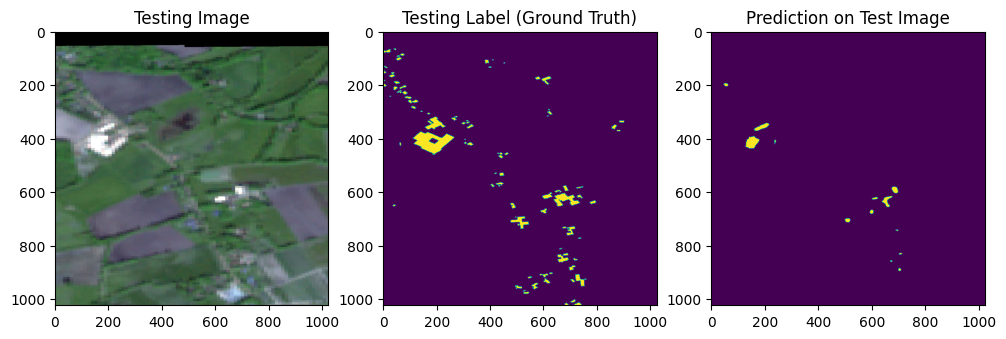

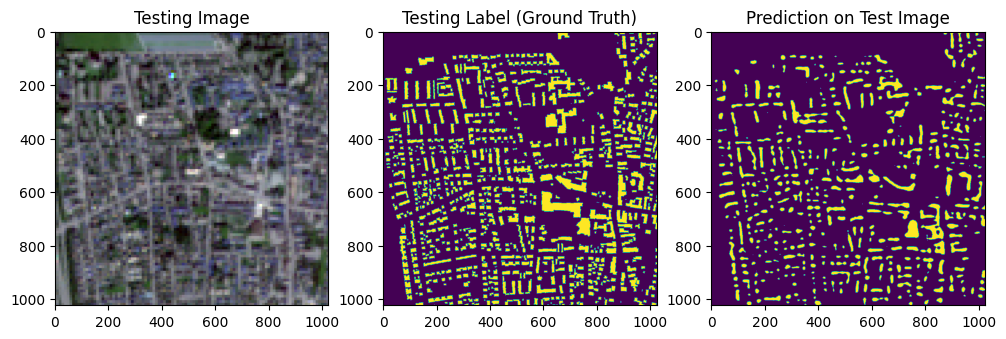

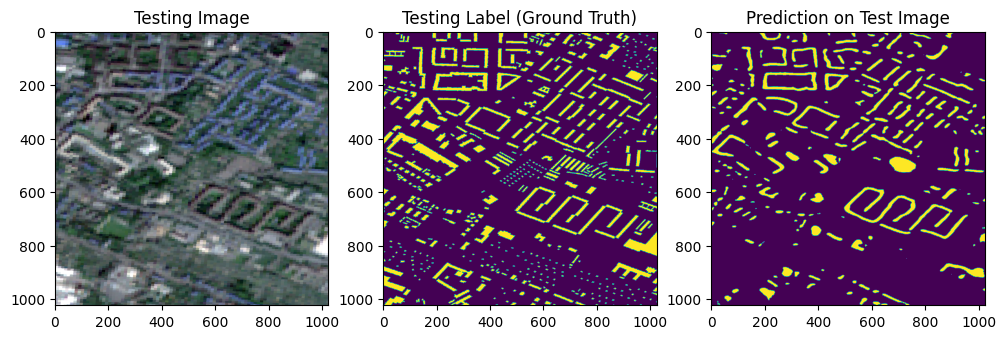

In [33]:
#### Test generators prediction results on test data 

import numpy as np
import matplotlib.pyplot as plt
import random

# Function to visualize random test samples with predictions
def visualize_random_predictions_from_test(test_generator, model, num_samples=3):
    # Ensure we don't exceed the available samples in the test set
    total_batches = len(test_generator)
    
    # Loop through a number of random samples
    for i in range(num_samples):
        # Randomly choose a batch from the test generator
        test_img_number = random.randint(0, total_batches - 1)
        
        # Extract the batch of images and labels from the generator
        test_batch = test_generator[test_img_number]
        test_img_batch = test_batch[0]  # X_test (batch of test images)
        test_label_batch = test_batch[1]  # y_test (batch of test labels)
        
        # Randomly choose one image from the batch
        batch_size = len(test_img_batch)
        random_index = random.randint(0, batch_size - 1)
        
        # Select the test image and its corresponding ground truth label
        test_img_single = test_img_batch[random_index]  # The chosen image
        ground_truth_single = test_label_batch[random_index]  # The corresponding ground truth
        
        # Predict the output for the selected test image
        test_img_input = np.expand_dims(test_img_single, 0)  # Expand dims to fit model input shape
        prediction = model.predict(test_img_input)
        predicted_img = np.argmax(prediction, axis=3)[0, :, :]  # Get the predicted class map
        
        # Plot the results: test image, ground truth, and prediction
        plt.figure(figsize=(12, 8))
        
        plt.subplot(131)
        plt.title('Testing Image')
        plt.imshow(test_img_single)
        
        plt.subplot(132)
        
        plt.title('Testing Label (Ground Truth)')
        plt.imshow(np.argmax(ground_truth_single, axis=2))  # Assuming one-hot encoded labels
        
        plt.subplot(133)
        plt.title('Prediction on Test Image')
        plt.imshow(predicted_img)
        
        plt.show()

# Call the function to visualize random predictions
visualize_random_predictions_from_test(test_generator, model, num_samples=3)


In [ ]:
### Predictions


### Checking the predictions 
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [ ]:
### Checking the predictions 
#IOU


import random
test_img_number = random.randint(0, len(X_test)- 1)
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
#print(prediction)



plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()


In [ ]:
#### Predictions for TIFF files

import  rasterio
import numpy as np
#from tifffile import imread, imwrite
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from rasterio.transform import from_origin
from patchify import patchify, unpatchify

# Parameters
image_patch_size = 1024
image_path = r"image_4839.tif"
model_path = r"Germany_1400images_1m_1024size_checkpoint_79_full_model.h5"
output_image_path = r"predicted_output_image_4839_1m.tif"


# Open the GeoTIFF file using rasterio
with rasterio.open(image_path) as src:
    image = src.read()  # Read all bands
    image = np.moveaxis(image, 0, -1)  # Reorder axes to (height, width, channels)
    
    # Keep the georeferencing information to save in the output TIFF
    transform = src.transform
    crs = src.crs

# Check if the image has more than 3 channels (e.g., RGBA or additional bands)
if image.shape[2] > 3:
    image = image[:, :, :3]  # Keep only the first 3 channels (RGB)

# Convert 16-bit unsigned integers to 8-bit integers (normalize to 0-255)
if image.dtype == np.uint16:  # Check if the image is 16-bit
    image = (image / 256).astype(np.uint8)  # Scale down to 8-bit (0-255)

# Resize image to be divisible by patch size
size_x = (image.shape[1] // image_patch_size) * image_patch_size
size_y = (image.shape[0] // image_patch_size) * image_patch_size

# Crop the image to match the patch size dimensions
image = image[:size_y, :size_x, ...]

print(f"Processing image with dimensions: {image.shape[0]}x{image.shape[1]}, Channels: {image.shape[2]}")

# Patchify the image into 256x256 patches
patched_images = patchify(image, (image_patch_size, image_patch_size, image.shape[2]), step=image_patch_size)

# Load the pre-trained model
model = load_model(model_path, compile=True, custom_objects={'jacard_coef': jacard_coef})

# Initialize MinMaxScaler for scaling patches
minmaxscaler = MinMaxScaler()

# Initialize placeholder for predicted patches
predicted_patches = np.zeros((patched_images.shape[0], patched_images.shape[1], image_patch_size, image_patch_size))

# Loop through each patch and make predictions
for i in range(patched_images.shape[0]):
    for j in range(patched_images.shape[1]):
        # Extract the individual patch
        individual_patched_image = patched_images[i, j, 0]

        # Apply MinMaxScaler to scale the patch
        individual_patched_image = minmaxscaler.fit_transform(
            individual_patched_image.reshape(-1, individual_patched_image.shape[-1])
        ).reshape(individual_patched_image.shape)

        # Expand dimensions to match model input (batch size, height, width, channels)
        patch_input = np.expand_dims(individual_patched_image, axis=0)

        # Predict the patch using the model
        predicted_patch = model.predict(patch_input)

        # Convert predicted patch to class labels (argmax over the channels)
        predicted_patch = np.argmax(predicted_patch, axis=3)[0]

        # Store the predicted patch (2D)
        predicted_patches[i, j] = predicted_patch

        # Display the original and predicted patch side by side (optional)
        # plt.figure(figsize=(8, 4))
        # plt.subplot(121)
        # plt.title(f'Original Patch [{i},{j}]')
        # plt.imshow(individual_patched_image)
        # plt.subplot(122)
        # plt.title(f'Predicted Patch [{i},{j}]')
        # plt.imshow(predicted_patch, cmap='gray')
        # plt.show()

# Unpatchify the predicted patches back into the full predicted image
predicted_image = unpatchify(predicted_patches, (size_y, size_x))

# Save the predicted image as a GeoTIFF
with rasterio.open(
    output_image_path, 'w', 
    driver='GTiff', 
    height=predicted_image.shape[0], 
    width=predicted_image.shape[1], 
    count=1,  # Since the output is single-channel (binary prediction)
    dtype=rasterio.uint8,  # Change the datatype based on your output (e.g., uint8)
    crs=crs, 
    transform=transform
) as dst:
    dst.write(predicted_image, 1)

print(f"Predicted output saved to {output_image_path}")       


In [ ]:
### For png file prediction

import os
import cv2
import numpy as np
from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Parameters
image_patch_size = 256
image_path = r"image_5588.png"
model_path = r"Germany_POC_2_150epoch_model_3000images_256size_checkpoint_142_full_model.h5"
#output_image_path = r"predicted_output_image_43.png"

# Load the image
image = cv2.imread(image_path, 1)

# Ensure the image dimensions are divisible by the patch size
size_x = (image.shape[1] // image_patch_size) * image_patch_size
size_y = (image.shape[0] // image_patch_size) * image_patch_size

# Crop the image to ensure dimensions are divisible by patch size
image = Image.fromarray(image)
image = image.crop((0, 0, size_x, size_y))
image = np.array(image)

# Patchify the image into 256x256 patches
patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

# Load the model
model = load_model(model_path, compile=False) ## if want  custom_objects={'jacard_coef': jacard_coef}

# Initialize MinMaxScaler for scaling the patches
minmaxscaler = MinMaxScaler()

# Initialize a placeholder for storing predicted patches (single channel)
predicted_patches = np.zeros((patched_images.shape[0], patched_images.shape[1], image_patch_size, image_patch_size))

# Loop through each patch and make predictions
for i in range(patched_images.shape[0]):
    for j in range(patched_images.shape[1]):
        # Extract the individual patch
        individual_patched_image = patched_images[i, j, 0]
        
        # Apply MinMaxScaler to scale the patch
        individual_patched_image = minmaxscaler.fit_transform(
            individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
        
        # Expand dimensions to match model input (batch size, height, width, channels)
        patch_input = np.expand_dims(individual_patched_image, axis=0)
        
        # Predict the patch using the model
        predicted_patch = model.predict(patch_input)
        
        # Convert predicted patch to class labels (argmax over the channels)
        predicted_patch = np.argmax(predicted_patch, axis=3)[0]  # The result is now (256, 256)
        
        # Store the predicted patch (2D)
        predicted_patches[i, j] = predicted_patch

        # Display the original and predicted patch side by side
        # plt.figure(figsize=(8, 4))
        # plt.subplot(121)
        # plt.title(f'Original Patch [{i},{j}]')
        # plt.imshow(individual_patched_image)
        # plt.subplot(122)
        # plt.title(f'Predicted Patch [{i},{j}]')
        # plt.imshow(predicted_patch, cmap='gray')
        # plt.show()

# Unpatchify if you want to reconstruct the full image (if you have multiple patches)
# full_image = unpatchify(predicted_patches, image.shape)


In [ ]:
# Unpatchify to reconstruct the image from the predicted patches
reconstructed_image = unpatchify(predicted_patches, (size_y, size_x))
label_image = cv2.imread(r"image_5588.png", cv2.IMREAD_GRAYSCALE)  # Modify the path accordingly

# Apply a color map to the reconstructed image for better visibility
#colored_reconstructed_image = cv2.applyColorMap(reconstructed_image.astype(np.uint8), cv2.COLORMAP_JET)

# Save the output image in high resolution with color
output_image = Image.fromarray(reconstructed_image)
#output_image.save(r'F:\Work\SantoshSV4\U-net_POC\Sentinel-2_Berlin_POC\Final_png_files_for_U-net_model\Final_files\predictions\sticted_predicted_image_1m_36.png')

# Plot the original image and the colorized reconstructed prediction
# Plot the original image, label image, and the colorized reconstructed prediction
plt.figure(figsize=(18, 8))

# Plot the original image
plt.subplot(131)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot the original label (ground truth)
plt.subplot(132)
plt.title('Original Label')
plt.imshow(label_image, cmap='gray')

# Plot the reconstructed prediction
plt.subplot(133)
plt.title('Reconstructed Prediction')
plt.imshow(reconstructed_image, cmap= 'gray')

# Show the plot
plt.show()


In [ ]:
###   Combine both predicted and original labels and save it in tiff and png file

import rasterio
import numpy as np
import cv2

# Load the predicted and original (ground truth) labels
with rasterio.open(r"predicted_676_image.tif") as src_pred:
    pred_labels = src_pred.read(1)
    profile = src_pred.profile  # We'll use this profile for the output TIFF

with rasterio.open(r"image_676.tif") as src_gt:
    gt_labels = src_gt.read(1)

# Threshold for building class (assuming buildings are labeled with 1)
pred_buildings = (pred_labels == 1).astype(np.uint8)
gt_buildings = (gt_labels == 1).astype(np.uint8)

# Initialize an RGB array to store the combined visualization
combined_rgb = np.zeros((pred_buildings.shape[0], pred_buildings.shape[1], 3), dtype=np.uint8)

# Apply red color for predicted building areas (fill with red color where predicted buildings are detected)
combined_rgb[pred_buildings == 1] = [255, 0, 0]  # Red fill for predicted buildings

# Find contours in the ground truth (original) labels
contours_gt, _ = cv2.findContours(gt_buildings, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw green boundaries for ground truth buildings
for cnt in contours_gt:
    cv2.drawContours(combined_rgb, [cnt], -1, (0, 255, 0), 1)  # Green boundary for ground truth buildings

# Update the profile for RGB output
profile.update(dtype=rasterio.uint8, count=3, photometric="RGB")

# Save the combined visualization to a new TIFF file
#output_tiff = r"C:\Germany\1m_s2_files\512\results\combined_predicted_and_original_labels_676.tif"
# with rasterio.open(output_tiff, "w", **profile) as dst:
#     dst.write(combined_rgb.transpose((2, 0, 1)))  # Transpose to (bands, rows, cols) format

# print(f"Combined labels saved as {output_tiff}")


# Save as a high-resolution PNG with compression
output_png = r"combined_predicted_and_original_labels_676.png"
# Convert the numpy array to an Image object for saving as PNG
img = Image.fromarray(combined_rgb)
img.save(output_png, format="PNG", dpi=(600, 600), optimize=True, compress_level=9)

print(f"Combined labels saved as high-resolution PNG: {output_png}")


In [ ]:
#### Final Code for conversion of polygons to shp and tiff file, preserving shapes

import rasterio
import cv2
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
from rasterio.features import rasterize

# Load the predicted TIFF file
with rasterio.open(r"image_2196.tif") as src_pred:
    pred_labels = src_pred.read(1)
    crs = src_pred.crs
    transform = src_pred.transform
    profile = src_pred.profile

# Threshold for building class (assuming buildings are labeled with 1)
pred_buildings = (pred_labels == 1).astype(np.uint8)

# Find contours of the building class
contours_pred, _ = cv2.findContours(pred_buildings, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert each contour to a simplified polygon in geographical coordinates
building_polygons = []
for cnt in contours_pred:
    # Simplify the contour while preserving the main shape
    epsilon = 0.01 * cv2.arcLength(cnt, True)  # Adjust epsilon for more or less simplification
    simplified_cnt = cv2.approxPolyDP(cnt, epsilon, True)
    
    # Convert contour coordinates from pixel to spatial (geographical) coordinates
    coordinates = [transform * (point[0][0], point[0][1]) for point in simplified_cnt]
    
    # Ensure at least 4 points for a valid Polygon
    if len(coordinates) >= 4:
        building_polygons.append(Polygon(coordinates))

# Combine polygons to remove overlaps or slight separations between nearby polygons
# This ensures that each building is represented as a single, unified polygon
merged_polygons = MultiPolygon(building_polygons).buffer(0)

# Create a GeoDataFrame with building polygons and assign CRS
gdf_pred = gpd.GeoDataFrame(geometry=[merged_polygons], crs=crs)

# Save to a shapefile
output_shapefile = r"predicted_building_shapes_2196_2.shp"
gdf_pred.to_file(output_shapefile, driver="ESRI Shapefile")
print(f"Building contours saved as polygons in shapefile: {output_shapefile}")

# Rasterize the polygons to create a TIFF file
output_raster = r"predicted_building_shapes_2196_2.tif"
with rasterio.open(
    output_raster,
    'w',
    driver='GTiff',
    height=pred_labels.shape[0],
    width=pred_labels.shape[1],
    count=1,
    dtype=rasterio.uint8,
    crs=crs,
    transform=transform,
) as dst:
    # Rasterize geometries with building polygons (value 1 for buildings, 0 otherwise)
    dst.write(
        rasterize(
            [(poly, 1) for poly in building_polygons],
            out_shape=pred_labels.shape,
            transform=transform,
            fill=0,
            dtype=rasterio.uint8
        ),
        indexes=1
    )

print(f"Rasterized building shapes saved as TIFF: {output_raster}")
